# EYE FOR BLIND
This notebook will be used to prepare the capstone project 'Eye for Blind'

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
#Import all the required libraries
import time
import re
import glob
from time import sleep
import pandas as pd
import numpy as np
from skimage import io
import matplotlib.pyplot as plt
import random
from collections import Counter
from wordcloud import WordCloud
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,Model
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu
import socket


Let's read the dataset

## Data understanding
1.Import the dataset and read image & captions into two seperate variables

2.Visualise both the images & text present in the dataset

3.Create word-to-index and index-to-word mappings.

4.Create a dataframe which summarizes the image, path & captions as a dataframe

5.Visualise the top 30 occuring words in the captions

6.Create a list which contains all the captions & path


In [3]:
in_nimble = False
in_WSL = False
in_tpu = False

host = socket.gethostname()
if('cuda' in host):
    in_nimble = True
    print("In NimbleBox")

In NimbleBox


In [4]:
#Import the dataset and read the image into a seperate variable
# images_path='Images'
# text_file = './captions.txt'
# images_path='/content/drive/MyDrive/TestImages'
# text_file = '/content/drive/MyDrive/captions_small.txt'
# images_path='/content/drive/MyDrive/Images/Images'
# text_file = '/content/drive/MyDrive/captions.txt'
# images_path='./Flickr8K/Images'
# text_file = './Flickr8K/captions.txt'
# images_path='TestImages'
# text_file = './captions_small.txt'

if(in_WSL == True):
    images_path='/home/suphale/snehal_bucket/test_images'
    text_file = '/home/suphale/snehal_bucket/test_images/captions.txt'
if(in_nimble == True):
    images_path='/mnt/disks/user/project/WorkSpace/test_images'
    text_file = '/mnt/disks/user/project/WorkSpace/test_images/captions.txt'

# Find out total number of images in the images folder
all_imgs = glob.glob(images_path + '/*.jpg',recursive=True)
all_imgs = sorted(all_imgs)
total_num_images = len(all_imgs)
print("The total images present in the dataset: {}".format(total_num_images))


The total images present in the dataset: 128


In [5]:
#Visualise both the images & text present in the dataset
print("The total images present in the dataset: {}".format(total_num_images))
num_lines = sum(1 for line in open(text_file))
print("The total number of lines in the caption file: {}".format(num_lines))



The total images present in the dataset: 128
The total number of lines in the caption file: 642


In [6]:
# define a function to clean text data
def extract_jpg_caption(line):
    char_filter = r"[^\w]"

    jpg_path = None
    caption = None

    jpg_position = line.find(".jpg")
    if(jpg_position != -1):
        jpg_path = images_path + '/' + line[:jpg_position+4]

        caption = line[jpg_position+5:].strip()

        # convert words to lower case
        caption = caption.lower()

        # split into words
        words = caption.split()

        # strip whitespace from all words
        words = [word.strip() for word in words]

        # join back words to get document
        caption = " ".join(words)

        # remove unwanted characters
        caption = re.sub(char_filter, " ", caption)

        # remove unwanted characters
        caption = re.sub(r"\.", " ", caption)

        # replace multiple whitespaces with single whitespace
        caption = re.sub(r"\s+", " ", caption)

        # strip whitespace from document
        caption = caption.strip()

        caption = '<start> ' + caption + ' <end>'

    return jpg_path, caption

In [7]:
#store all the image id here
all_img_id= [] 
#store all the image path here
all_img_vector=[]
#store all the captions here
annotations= [] 
# list of all captions in word list format
annotations_word_list = []

In [8]:
def load_doc(filename):
    #your code here
    file  = open(filename, 'r') 
    Lines = file.readlines() 
    
    text = ""
    count = 0
    for line in Lines:
        jpg_path, caption = extract_jpg_caption(line)
        if(jpg_path != None):
            all_img_id.append(count)
            all_img_vector.append(jpg_path)
            annotations.append(caption)
            word_list = caption.split()
            annotations_word_list.append(word_list)
            text += " " + caption
            count += 1
    file.close()
    return text

In [9]:
#Import the dataset and read the text file into a seperate variable
doc = load_doc(text_file)
print(doc[:300])

 <start> fast food displayed on a table with sandwich and soup <end> <start> a sandwich and soup sit on a table <end> <start> a burger sitting next to a cup of soup and crackers <end> <start> a hamburger and a cup of soup on a table <end> <start> a table that has some food on it <end> <start> many g


In [10]:
annotations[:2]

['<start> fast food displayed on a table with sandwich and soup <end>',
 '<start> a sandwich and soup sit on a table <end>']

Randomly pick an image from the data and show its corresponding caption


<start> a table with some bananas and pickles on it <end>


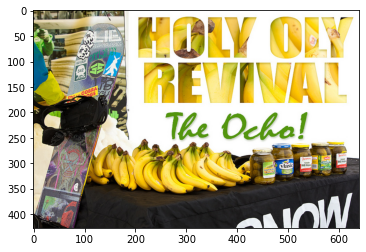

In [11]:
random_num = random.randint(0,total_num_images-1)
print(annotations[random_num])
img_path = all_img_vector[random_num]
image = io.imread(img_path)
plt.imshow(image)


In [12]:
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_vector)))
total_images = len(all_img_vector)

Total captions present in the dataset: 640
Total images present in the dataset: 640


Create a dataframe which summarizes the image, path & captions as a dataframe

Each image id has 5 captions associated with it therefore the total dataset should have 40455 samples.

In [13]:
df = pd.DataFrame(list(zip(all_img_id, all_img_vector,annotations)),columns =['ID','Path', 'Captions']) 
    
df

,ID,Path,Captions
0,0,/mnt/disks/user/project/WorkSpace/test_images/...,<start> fast food displayed on a table with sa...
1,1,/mnt/disks/user/project/WorkSpace/test_images/...,<start> a sandwich and soup sit on a table <end>
2,2,/mnt/disks/user/project/WorkSpace/test_images/...,<start> a burger sitting next to a cup of soup...
3,3,/mnt/disks/user/project/WorkSpace/test_images/...,<start> a hamburger and a cup of soup on a tab...
4,4,/mnt/disks/user/project/WorkSpace/test_images/...,<start> a table that has some food on it <end>
...,...,...,...
635,635,/mnt/disks/user/project/WorkSpace/test_images/...,<start> a white truck driving by a street sign...
636,636,/mnt/disks/user/project/WorkSpace/test_images/...,<start> various items in the bed of a white tr...
637,637,/mnt/disks/user/project/WorkSpace/test_images/...,<start> miscellaneous tools in the bed of a wh...
638,638,/mnt/disks/user/project/WorkSpace/test_images/...,<start> back of a white pick up truck going do...


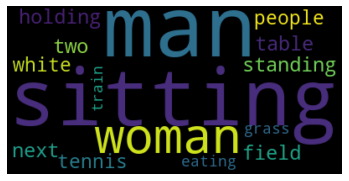

In [14]:
# Visualise the top 30 occuring words in the captions
vocabulary = [word for word in doc.split()] #write your code here
val_count = Counter(vocabulary)

str_list = ""
for x,y in val_count.most_common(32):
    if(x!='<start>') and (x!='<end>'):
        str_list += " " + x
wordcloud = WordCloud().generate(str_list)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


In [15]:
print("Total captions present in the dataset: "+ str(len(annotations)))
print("Total images present in the dataset: " + str(len(all_img_vector)))

Total captions present in the dataset: 640
Total images present in the dataset: 640


## Pre-Processing the captions
1.Create the tokenized vectors by tokenizing the captions fore ex :split them using spaces & other filters. 
This gives us a vocabulary of all of the unique words in the data. Keep the total vocaublary to top 5,000 words for saving memory.

2.Replace all other words with the unknown token "UNK" .

3.Create word-to-index and index-to-word mappings.

4.Pad all sequences to be the same length as the longest one.

In [16]:
# create the tokenizer

# your code here
max_tokenized_words = 5000

tokenizer = Tokenizer(num_words=max_tokenized_words+1,oov_token='<unknown>')
tokenizer.fit_on_texts(annotations_word_list)


In [17]:
# Create word-to-index and index-to-word mappings.
VOCABULARY_SIZE = len(tokenizer.word_index) + 1
print('Vocabulary Size: {}'.format(VOCABULARY_SIZE))

print("index of dog = %d" % (tokenizer.word_index['dog']))
print("word corresponding to index 10 = %s" % (tokenizer.index_word[10]))


Vocabulary Size: 1046
index of dog = 87
word corresponding to index 10 = and


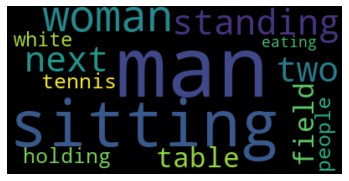

In [18]:
# Create a word count of your tokenizer to visulize the Top 30 occuring words after text processing
data = tokenizer.word_counts
# print(j)
sorted_word_list = sorted(data.items(), key=lambda x:x[1], reverse=True)
str_list = ""
for i in range(30):
    x,y = sorted_word_list[i]
    if(x!='<start>') and (x!='<end>'):
        str_list += " " + x

wordcloud = WordCloud().generate(str_list)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()    


24


/mnt/disks/user/anaconda3/envs/cuda101/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


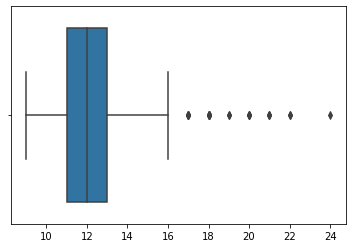

In [19]:
# Pad each vector to the max_length of the captions ^ store it to a vairable

MAX_SEQ_LENGTH = 25

cap_vector = annotations_word_list
Y_encoded = tokenizer.texts_to_sequences(cap_vector)
cap_vector_encoded_padded = pad_sequences(Y_encoded, maxlen=MAX_SEQ_LENGTH, padding="post", truncating="post")

list_len = [len(i) for i in Y_encoded]
print(max(list_len))

sns.boxplot(list_len)
plt.show()
# print("The shape of Caption vector is :" + str(cap_vector.shape))

## Pre-processing the images

1.Resize them into the shape of (299, 299)

3.Normalize the image within the range of -1 to 1, such that it is in correct format for InceptionV3. 

In [20]:
#write your code here
batch_size = 32
def read_image(image_path,label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (299, 299))
    image = tf.cast(image, tf.float32)
    image /= 127.5
    image -= 1.
    return image, label


## Create the train & test data 
1.Combine both images & captions to create the train & test dataset using tf.data.Dataset API. Create the train-test spliit using 80-20 ratio & random state = 42

2.Make sure you have done Shuffle and batch while building the dataset

3.The shape of each image in the dataset after building should be (batch_size, 299, 299, 3)

4.The shape of each caption in the dataset after building should be(batch_size, max_len)


split the data into train, validation and final test sets

In [21]:
from sklearn.model_selection import train_test_split

# split the data into train, validation and final test sets
img_train, final_img_test, cap_train, final_cap_test = train_test_split(all_img_vector, cap_vector_encoded_padded, test_size=0.01, random_state=42)
img_train, img_test, cap_train, cap_test = train_test_split(img_train, cap_train, test_size=0.2, random_state=42)

total_training_images = len(img_train)
total_test_images = len(img_test)
total_final_testing_images = len(final_img_test)
print("Total Images for training=%d" % (total_training_images))
print("Total Images for testing (validation)=%d" % (total_test_images))
print("Total Images for final random testing=%d" % (total_final_testing_images))



Total Images for training=506
Total Images for testing (validation)=127
Total Images for final random testing=7


In [22]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_train, cap_train))
test_dataset = tf.data.Dataset.from_tensor_slices((img_test, cap_test))
final_test_dataset = tf.data.Dataset.from_tensor_slices((final_img_test, final_cap_test))


In [23]:
#write your code here
train_dataset = train_dataset.map(read_image)
train_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

test_dataset = test_dataset.map(read_image)
test_dataset.shuffle(buffer_size=1024,reshuffle_each_iteration=True)
test_dataset = test_dataset.batch(batch_size)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

A utility function to display image retrieved from a dataset and its corresponding caption

In [24]:
# A utility function to display image retrieved from a dataset and its corresponding caption
def show_image_caption_from_dataset(image,label):
    plt.imshow(image)
    for x in label.numpy():
        if(x != 0):
            print(tokenizer.index_word[x], end =" ")


Check that the data retrieved from dataset is in correct format

(32, 299, 299, 3)
(32, 25)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<start> a lonely single zebra in the zoo pen <end> 

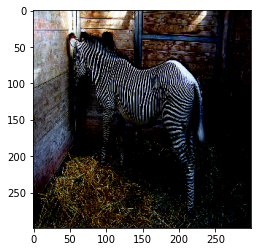

In [25]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
# (batch_size, 299, 299, 3)
print(sample_img_batch.shape) 
# (batch_size, max_len)
print(sample_cap_batch.shape) 
show_image_caption_from_dataset(sample_img_batch[0],sample_cap_batch[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(32, 299, 299, 3)
(32, 25)
<start> a child eats food from a black container next to a carton of milk <end> 

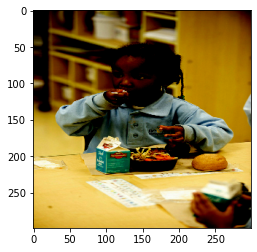

In [26]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
# (batch_size, 299, 299, 3)
print(sample_img_batch.shape) 
# (batch_size, max_len)
print(sample_cap_batch.shape) 
show_image_caption_from_dataset(sample_img_batch[0],sample_cap_batch[0])

## Load the pretrained Imagenet weights of Inception net V3

1.To save the memory(RAM) from getting exhausted, extract the features of thei mage using the last layer of pre-trained model. Including this as part of training will lead to higher computational time.

2.The shape of the output of this layer is 8x8x2048. 

3.Use a function to extract the features of each image in the train & test dataset such that the shape of each image should be (batch_size, 8*8, 2048)



In [27]:
image_model = tf.keras.applications.InceptionV3(include_top=False,weights='imagenet')

# write code here to get the input of the image_model
new_input = image_model.input 
# write code here to get the output of the image_model
hidden_layer = image_model.output 

#build the final model using both input & output layer
image_features_extract_model = keras.Model(inputs=new_input, outputs=hidden_layer)

87916544/87910968 [==============================] - 1s 0us/step


In [28]:
model_json = image_features_extract_model.to_json()
with open("image_features_extract_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
image_features_extract_model.save_weights("image_features_extract_model.h5")
print("Saved image_features_extract_model to disk")

Saved image_features_extract_model to disk


In [29]:
# image_model.summary()

In [30]:
# write your code to extract features from each image in the dataset
def extract_image_features(sample_img_batch):
    features = image_features_extract_model(sample_img_batch)
    features = tf.reshape(features, [sample_img_batch.shape[0],8*8, 2048])
    return features


In [31]:
sample_img_batch, sample_cap_batch = next(iter(train_dataset))
sample_img_batch = extract_image_features(sample_img_batch)
# (batch_size, 8*8, 2048)
print("sample_img_batch.shape after extract_image_features",sample_img_batch.shape)  
# (batch_size,40)
print("sample_cap_batch.shape after extract_image_features",sample_cap_batch.shape) 

sample_img_batch.shape after extract_image_features (32, 64, 2048)
sample_cap_batch.shape after extract_image_features (32, 25)


In [32]:
sample_img_batch, sample_cap_batch = next(iter(test_dataset))
sample_img_batch = extract_image_features(sample_img_batch)
# (batch_size, 8*8, 2048)
print("sample_img_batch.shape after extract_image_features",sample_img_batch.shape)  
# (batch_size,40)
print("sample_cap_batch.shape after extract_image_features",sample_cap_batch.shape) 

sample_img_batch.shape after extract_image_features (32, 64, 2048)
sample_cap_batch.shape after extract_image_features (32, 25)


## Model Building
1.Set the parameters

2.Build the Encoder, Attention model & Decoder

In [33]:
embedding_dim = 256 
units = 512
vocab_size = max_tokenized_words + 1
train_num_steps = total_training_images //batch_size #len(total train images) // BATCH_SIZE
test_num_steps = total_test_images //batch_size #len(total test images) // BATCH_SIZE

### Encoder

In [34]:
class Encoder(Model):
    def __init__(self,embed_dim):
        super(Encoder, self).__init__()
        # build your Dense layer with relu activation
        self.dense = tf.keras.layers.Dense(embed_dim, activation='relu')
        
    def call(self, features):
        # extract the features from the image shape: (batch, 8*8, embed_dim)
        features = self.dense(features)
        return features    

In [35]:
encoder=Encoder(embedding_dim)

### Attention model

In [36]:
from tensorflow.keras.activations import tanh
from tensorflow.keras.activations import softmax

class Attention_model(Model):
    def __init__(self, units):
        super(Attention_model, self).__init__()
        self.units=units
        # build your Dense layer
        self.W1 = tf.keras.layers.Dense(units)
        # build your Dense layer
        self.W2 = tf.keras.layers.Dense(units)
        # build your final Dense layer with unit 1
        # self.V = tf.keras.layers.Dense(1, activation='softmax')
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features shape: (batch_size, 8*8, embedding_dim)
        # hidden shape: (batch_size, hidden_size)
        
        # Expand the hidden shape to shape: (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        # build your score funciton to shape: (batch_size, 8*8, units)
        score = tanh(self.W1(features) + self.W2(hidden_with_time_axis))
        # extract your attention weights with shape: (batch_size, 8*8, 1)
        score = self.V(score)
        attention_weights = softmax(score, axis=1)

        # shape: create the context vector with shape (batch_size, 8*8,embedding_dim)
        context_vector = attention_weights * features
        # reduce the shape to (batch_size, embedding_dim)
        # context_vector = tf.reduce_sum(context_vector, axis=1)
        context_vector = tf.reduce_mean(context_vector, axis=1)

        return context_vector, attention_weights        

### Decoder

In [37]:
class Decoder(Model):
    def __init__(self, embed_dim, units, vocab_size):
        super(Decoder, self).__init__()
        self.units = units
        # iniitalise your Attention model with units
        self.attention = Attention_model(self.units)
        # build your Embedding layer
        self.embed = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,return_sequences=True,return_state=True,recurrent_initializer='glorot_uniform')
        # build your Dense layer
        self.d1 = tf.keras.layers.Dense(self.units)
        # build your Dense layer
        self.d2 = tf.keras.layers.Dense(vocab_size)


    def call(self,x,features, hidden):
        #create your context vector & attention weights from attention model
        context_vector, attention_weights = self.attention(features, hidden)
        # embed your input to shape: (batch_size, 1, embedding_dim)
        embed = self.embed(x)
        # Concatenate your input with the context vector from attention layer. 
        # Shape: (batch_size, 1, embedding_dim + embedding_dim)
        embed = tf.concat([tf.expand_dims(context_vector, 1), embed], axis=-1)
        # Extract the output & hidden state from GRU layer. 
        # Output shape : (batch_size, max_length, hidden_size)
        output, state = self.gru(embed)
        output = self.d1(output)
        # shape : (batch_size * max_length, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2])) 
        # shape : (batch_size * max_length, vocab_size)
        output = self.d2(output)

        return output, state, attention_weights

    def init_state(self, batch_size):
        return tf.zeros((batch_size, self.units))

In [38]:
decoder=Decoder(embedding_dim, units, vocab_size)

In [39]:
features=encoder(sample_img_batch)

hidden = decoder.init_state(batch_size=sample_cap_batch.shape[0])
dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * sample_cap_batch.shape[0], 1)

predictions, hidden_out, attention_weights= decoder(dec_input, features, hidden)
print('Feature shape from Encoder: {}'.format(features.shape)) #(batch, 8*8, embed_dim)
print('Predcitions shape from Decoder: {}'.format(predictions.shape)) #(batch,vocab_size)
print('Attention weights shape from Decoder: {}'.format(attention_weights.shape)) #(batch, 8*8, embed_dim)

Feature shape from Encoder: (32, 64, 256)
Predcitions shape from Decoder: (32, 5001)
Attention weights shape from Decoder: (32, 64, 1)


## Model training & optimization
1.Set the optimizer & loss object

2.Create your checkpoint path

3.Create your training & testing step functions

4.Create your loss function for the test dataset

In [40]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')


In [41]:
def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

In [42]:
checkpoint_path = "./ckpt"
ckpt = tf.train.Checkpoint(encoder=encoder,
                           decoder=decoder,
                           optimizer = optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

In [43]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])

In [44]:
#@tf.function
def train_step(img_tensor, target):
    loss = 0
    hidden = decoder.init_state(batch_size=target.shape[0])
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    img_tensor = extract_image_features(img_tensor)

    with tf.GradientTape() as tape:
        # Get the fixed length vector of Encoder-Decoder model
        features = encoder(img_tensor)
        # Loop through for max_length times
        for i in range(1, target.shape[1]):
            # Get predictions from the decoder
            predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # Get the next target vector as dec_input
            dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    trainable_variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, trainable_variables)

    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return loss, total_loss

In [45]:
#@tf.function
def test_step(img_tensor, target):
    #write your code here to do the testing steps
    loss = 0

    hidden = decoder.init_state(batch_size=target.shape[0])
    img_tensor = extract_image_features(img_tensor)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * target.shape[0], 1)

    features = encoder(img_tensor)

    for i in range(1, target.shape[1]):
        predictions, hidden, _ = decoder(dec_input, features, hidden)

        loss += loss_function(target[:, i], predictions)

        dec_input = tf.expand_dims(target[:, i], 1)

    total_loss = (loss / int(target.shape[1]))

    return loss, total_loss

In [46]:
def test_loss_cal(test_dataset):
    total_loss = 0

    #write your code to get the average loss result on your test data
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(test_dataset):
        batch_loss, t_loss = test_step(img_tensor, target)
        total_loss += t_loss
        avg_test_loss=total_loss / test_num_steps
    
    return avg_test_loss

In [47]:
loss_plot = []
test_loss_plot = []
EPOCHS = 15

best_test_loss=100
for epoch in tqdm(range(0, EPOCHS)):
    start = time.time()
    total_loss = 0

    for (batch, (img_tensor, target)) in enumerate(train_dataset):
        batch_loss, t_loss = train_step(img_tensor, target)
        total_loss += t_loss
        avg_train_loss=total_loss / train_num_steps
        
    loss_plot.append(avg_train_loss)    

    test_loss = test_loss_cal(test_dataset)
    test_loss_plot.append(test_loss)
    
    print ('For epoch: {}, the train loss is {:.3f}, & test loss is {:.3f}'.format(epoch+1,avg_train_loss,test_loss))
    print ('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    
    if test_loss < best_test_loss:
        print('Test loss has been reduced from %.3f to %.3f' % (best_test_loss, test_loss))
        best_test_loss = test_loss
        ckpt_manager.save()

  0%|          | 0/15 [00:00<?, ?it/s]

For epoch: 1, the train loss is 3.456, & test loss is 3.388
Time taken for 1 epoch 60.776965618133545 sec

Test loss has been reduced from 100.000 to 3.388


 13%|█▎        | 2/15 [01:15<07:19, 33.83s/it]

For epoch: 2, the train loss is 2.478, & test loss is 3.283
Time taken for 1 epoch 14.54818844795227 sec

Test loss has been reduced from 3.388 to 3.283


 20%|██        | 3/15 [01:30<05:00, 25.05s/it]

For epoch: 3, the train loss is 2.336, & test loss is 3.250
Time taken for 1 epoch 14.455897331237793 sec

Test loss has been reduced from 3.283 to 3.250


 27%|██▋       | 4/15 [01:44<03:49, 20.82s/it]

For epoch: 4, the train loss is 2.226, & test loss is 3.191
Time taken for 1 epoch 14.222925424575806 sec

Test loss has been reduced from 3.250 to 3.191


 33%|███▎      | 5/15 [01:59<03:04, 18.49s/it]

For epoch: 5, the train loss is 2.104, & test loss is 3.116
Time taken for 1 epoch 14.206716299057007 sec

Test loss has been reduced from 3.191 to 3.116


 40%|████      | 6/15 [02:13<02:33, 17.10s/it]

For epoch: 6, the train loss is 2.022, & test loss is 3.102
Time taken for 1 epoch 14.264890432357788 sec

Test loss has been reduced from 3.116 to 3.102


 47%|████▋     | 7/15 [02:28<02:10, 16.27s/it]

For epoch: 7, the train loss is 1.945, & test loss is 3.109
Time taken for 1 epoch 14.542609930038452 sec



 53%|█████▎    | 8/15 [02:42<01:49, 15.61s/it]

For epoch: 8, the train loss is 1.862, & test loss is 3.151
Time taken for 1 epoch 14.198541402816772 sec



 60%|██████    | 9/15 [02:56<01:30, 15.17s/it]

For epoch: 9, the train loss is 1.794, & test loss is 3.238
Time taken for 1 epoch 14.189616203308105 sec



 67%|██████▋   | 10/15 [03:10<01:14, 14.91s/it]

For epoch: 10, the train loss is 1.734, & test loss is 3.306
Time taken for 1 epoch 14.346835374832153 sec



 73%|███████▎  | 11/15 [03:25<00:58, 14.72s/it]

For epoch: 11, the train loss is 1.679, & test loss is 3.420
Time taken for 1 epoch 14.275777816772461 sec



 80%|████████  | 12/15 [03:39<00:43, 14.58s/it]

For epoch: 12, the train loss is 1.627, & test loss is 3.504
Time taken for 1 epoch 14.272891283035278 sec



 87%|████████▋ | 13/15 [03:53<00:28, 14.44s/it]

For epoch: 13, the train loss is 1.576, & test loss is 3.567
Time taken for 1 epoch 14.115703821182251 sec



 93%|█████████▎| 14/15 [04:07<00:14, 14.37s/it]

For epoch: 14, the train loss is 1.527, & test loss is 3.610
Time taken for 1 epoch 14.196942329406738 sec



100%|██████████| 15/15 [04:22<00:00, 17.47s/it]

For epoch: 15, the train loss is 1.480, & test loss is 3.639
Time taken for 1 epoch 14.38448190689087 sec



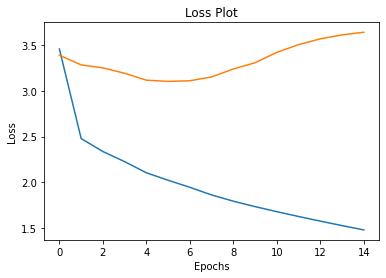

In [48]:
plt.plot(loss_plot)
plt.plot(test_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

## Model Evaluation
1.Define your evaluation function using greedy search

2.Define your evaluation function using beam search ( optional)

3.Test it on a sample data using BLEU score

### Greedy Search

In [49]:
def evaluate(image):
    attention_features_shape = 64
    attention_plot = np.zeros((MAX_SEQ_LENGTH, attention_features_shape))

    hidden = decoder.init_state(batch_size=1)

    # process the input image to desired format before extracting features
    temp_input = tf.expand_dims(read_image(image,[])[0], 0) 
    # Extract features using our feature extraction model
    img_tensor_val = extract_image_features(temp_input)
    # img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))

    # extract the features by passing the input to encoder
    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(MAX_SEQ_LENGTH):
        # get the output from decoder
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        #extract the predicted id(embedded value) which carries the max value
        predicted_id = tf.argmax(tf.transpose(predictions))
        predicted_id = predicted_id.numpy()[0]
        # map the id to the word from tokenizer and append the value to the result list
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot,predictions

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot,predictions


### Beam Search(optional)

In [50]:
def beam_evaluate(image, beam_index = 0): #your value for beam index):

    final_caption = "ToDo"
    #write your code to evaluate the result using beam search
                  
    return final_caption


In [51]:
from PIL import Image
def plot_attmap(caption, weights, image):

    fig = plt.figure(figsize=(10, 10))
    temp_img = np.array(Image.open(image))
    
    len_cap = len(caption)
    for cap in range(len_cap):
        weights_img = np.reshape(weights[cap], (8,8))
        weights_img = np.array(Image.fromarray(weights_img).resize((224, 224), Image.LANCZOS))
        
        ax = fig.add_subplot((len_cap//2)+1, (len_cap//2)+1, cap+1)
        ax.set_title(caption[cap], fontsize=15)
        
        img=ax.imshow(temp_img)
        
        ax.imshow(weights_img, cmap='gist_heat', alpha=0.6,extent=img.get_extent())
        ax.axis('off')
    plt.subplots_adjust(hspace=0.2, wspace=0.2)
    plt.show()

In [52]:
def filt_text(text):
    filt=['<start>','<unk>','<end>'] 
    temp= text.split()
    [temp.remove(j) for k in filt for j in temp if k==j]
    text=' '.join(temp)
    return text

Time elapsed:  21.927269048000085
BLEU score: 3.0197383422318502
Real Caption: a group of men sitting together at a table
Prediction Caption: a table


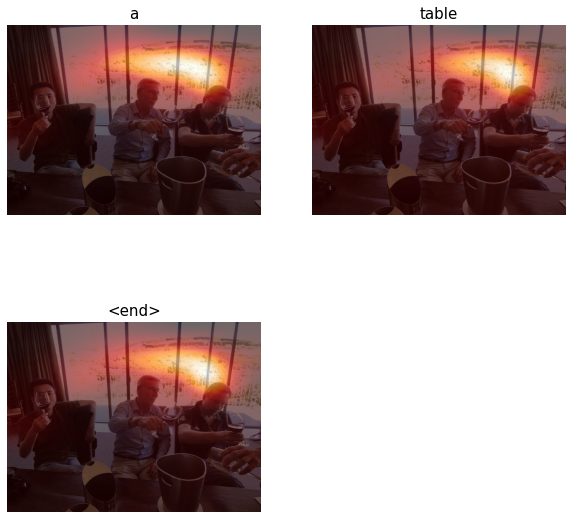

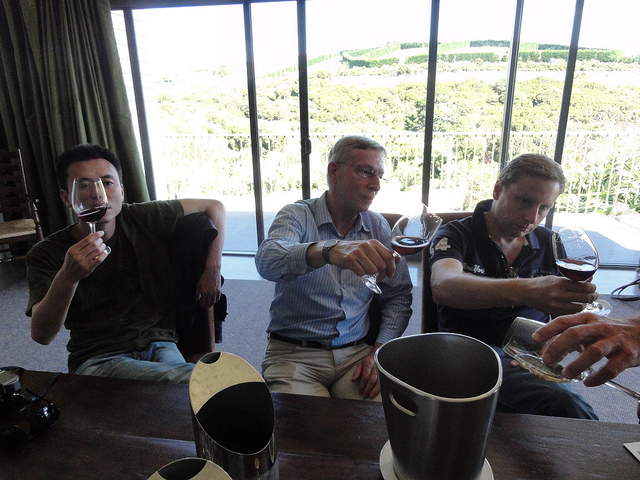

In [54]:
import time
rid = np.random.randint(0, total_final_testing_images)
test_image = final_img_test[rid]
# test_image = './Images/413231421_43833a11f5.jpg'
# test_image = '/content/drive/MyDrive/TestImages/3637013_c675de7705.jpg'

real_caption = final_cap_test[rid]
# real_caption = '<start> A couple stands close at the water edge <end>'
# real_caption = '<start> black dog is digging in the snow <end>'
real_caption = ' '.join([tokenizer.index_word[i] for i in final_cap_test[rid] if i not in [0]])

t0= time.perf_counter()
result, attention_plot,pred_test = evaluate(test_image)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)

real_caption=filt_text(real_caption)      

pred_caption=' '.join(result).rsplit(' ', 1)[0]

real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = pred_caption.split()

score = sentence_bleu(reference, candidate, weights=[1]) #set your weights)
print(f"BLEU score: {score*100}")

print ('Real Caption:', real_caption)
print ('Prediction Caption:', pred_caption)
plot_attmap(result, attention_plot, test_image)


Image.open(test_image)

In [ ]:
captions=beam_evaluate(test_image)
print(captions)

In [ ]:
# import pyttsx3
# engine = pyttsx3.init()
# engine.say("I will speak this text")
# engine.runAndWait()

In [ ]:
convert_to_audio = False
if (convert_to_audio == True):
  from gtts import gTTS 
  import os 

  gtts_obj = gTTS(text=pred_caption, lang='en', slow=False)
  gtts_obj.save("caption_to_text.mp3") 


In [ ]:
# image_features_extract_model.summary()

In [ ]:
encoder.summary()

In [ ]:
decoder.summary()

In [ ]:
type(decoder)

In [ ]:
# decoder_model_json = decoder.to_json()
# with open("decoder.json", "w") as json_file:
#     json_file.write(decoder_model_json)
# decoder.save_weights("decoder.h5")
# print("Saved decoder to disk")